In [1]:
import vtk
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial import KDTree
from scipy.interpolate import RegularGridInterpolator
from scipy.signal import savgol_filter
import pygmt
import importlib
import pandas as pd
import h5py
from scipy.special import erf
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
import matplotlib.patches as patches

os.chdir("../")
import parallel_curves
os.chdir("scripts_for_figures")

In [2]:
def log_RMS_misfit(naif_data, pylith_data):
    N = len(pylith_data)
    log_difference = (np.log10(pylith_data) - np.log10(naif_data))**2
    log_rms_error = np.sqrt(1/N * np.sum(log_difference))
    return log_rms_error

def log_absolute_misfit(naif_data, pylith_data):
    N = len(pylith_data)
    log_difference = abs(np.log10(pylith_data) - np.log10(naif_data))
    log_error = 1/N * np.sum(log_difference)
    return log_error

def RMS_misfit(naif_data, pylith_data):
    N = len(pylith_data)
    difference = (pylith_data - naif_data)**2
    rms_error = np.sqrt(1/N * np.sum(difference))
    return rms_error

# Load in Naif et al., Datasets

In [3]:
porosity = pd.read_excel('../../data_files/porosity_SERPENT_outerrise.xlsx', header=None).to_numpy()
resistivity = pd.read_excel('../../data_files/resistivity_SERPENT_outerrise.xlsx', header=None).to_numpy()

trench_distance = np.flip(np.arange(0, 100.1, 0.1))
depth_resistivity = np.arange(0, 12.75, 0.05)
depth_porosity = np.arange(0, 10., 0.05)

X_POR, Z_POR = np.meshgrid(trench_distance, depth_porosity)
X_RES, Z_RES = np.meshgrid(trench_distance, depth_resistivity)

# We do not include the sediment layer in our model. Set the resistivity of the sediments 
# in the Naif dataset to NAN's so that it doesn't impact our comparison. They define the
# sediment layer as being below a resistivity of 3.5 ohm meter. This occurs at roughly a
# depth of 500 m.
# basement_resistivity = 3.5
# resistivity[resistivity <= 3.5] = np.nan
X_POR = X_POR[10:, :]
Z_POR = Z_POR[10:, :] - 0.5
porosity = porosity[10:, :]

X_POR = X_POR[:, 0:-50]
Z_POR = Z_POR[:, 0:-50]
porosity = porosity[:, 0:-50]

X_RES = X_RES[10:, :]
Z_RES = Z_RES[10:, :] - 0.5
resistivity = resistivity[10:, :]

X_RES = X_RES[:, 0:-50]
Z_RES = Z_RES[:, 0:-50]
resistivity = resistivity[:, 0:-50]

# Try doing the depth averaged binned calculation for the Porosity (Figure 9 from Naif et al.,)

In [4]:
def depth_average_porosity(base_x, bin_sizes, X_POR, Z_POR, POROSITY):
    '''
    base_x = the initial value to start binning the data (double)
    bin_sizes = an array of doubles that specifies the width of the bins. The first bin will start
                at base_x, and the subsequent bins will be shifted by the size of the previous bins.
    X_POR  = uniform mesh that specifies the x-values of the grid
    Z_POR  = uniform mesh that specifies the z-values of the grid
    POROSITY = uniform mesh that specifies the porosity values on the grid

    Returns:
    An array (object) that contains the depth averaged porosity within each bin, and an array that
    specifies the depths of the depth averaging.
    '''
    # Create an array to store the depth averages. There must be the same
    # number of depth averaged curves as there are the number of bins.
    depth_averaged_por = np.zeros(len(bin_sizes), dtype=object)
    z_vals_for_bins = np.unique(Z_POR.flatten())
    
    for i in range(len(bin_sizes)):
        average_por_at_z_vals = np.zeros(len(z_vals_for_bins))
        for j in range(len(z_vals_for_bins)):
    
            por_indices = np.where( (X_POR.flatten() >= base_x) & (X_POR.flatten() <= base_x + bin_sizes[i]) & (Z_POR.flatten() == z_vals_for_bins[j]) )
            por_at_current_z = POROSITY.flatten()[por_indices]
            average_por_at_z_vals[j] = np.average(por_at_current_z)
    
        depth_averaged_por[i] = average_por_at_z_vals
        base_x += bin_sizes[i]

    return z_vals_for_bins, depth_averaged_por

In [5]:
base_x = 5
bin_sizes = np.array([15, 20, 20, 20, 20])
z_vals_for_bins, depth_averaged_por = depth_average_porosity(base_x, bin_sizes, X_POR, Z_POR, porosity)

In [6]:
base_dir = "/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/CAM_outerrise/PUBLICATION_MODELS/"
perm_model = "hatakeyama/"

pylith_models = np.array(["step01_no_faults_no_flexure",
                          "step03_faults_no_flexure",
                          "step02_no_faults_with_flexure",
                          "step04_faults_with_flexure_2.5x", 
                          "step04_faults_with_flexure_5x",
                          "step04_faults_with_flexure_10x",
                          "step04_faults_with_flexure_25x",
                          "step04_faults_with_flexure_100x"])

# pylith_models = np.array(["step05_rupture_faults_no_perm_faults_low_tol"])

porosity_file = np.loadtxt(fname=base_dir + "data_files/ave_NAIF_porosity.txt")
depth_averages_for_models_ha = np.zeros(len(pylith_models), dtype=object)

for i in range(len(pylith_models)):
    data_filename  = pylith_models[i] + "-subducting.h5"
    data_file_path = base_dir + perm_model + pylith_models[i] + '/' + data_filename
    
    with h5py.File(data_file_path, 'r') as f:
        total_porosity = f["vertex_fields"]["porosity"][:]
        total_water_content = f["vertex_fields"]["water_content"][:]
        final_porosity = total_porosity[-1]
        final_water_content = total_water_content[-1]
        
        vertices = f["geometry/vertices"]
        x_vals = vertices[:, 0]
        y_vals = vertices[:, 1]
    
        pylith_porosity = np.zeros(len(y_vals))
        for j in range(len(pylith_porosity)):
            depth_index = np.abs(y_vals[j] + porosity_file[:, 0] * 1e3).argmin()
            pylith_porosity[j] = porosity_file[:, 1][depth_index] + final_water_content[j][0]

        outerrise_x_vals   = abs(x_vals[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )] / 1e3)
        outerrise_y_vals   = abs(y_vals[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )] / 1e3)
        
        outerrise_porosity   = final_porosity[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )]
        # outerrise_porosity   = pylith_porosity[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )]

        pylith_naif_porosity = np.zeros(len(Z_POR.flatten()))
        naif_KDTREE = KDTree(np.c_[outerrise_x_vals, outerrise_y_vals])
        
        for j in range(len(pylith_naif_porosity)):
            dd, ii = naif_KDTREE.query([X_POR.flatten()[j], Z_POR.flatten()[j]])
            pylith_naif_porosity[j] = outerrise_porosity.flatten()[ii]

    z_vals_for_bins, depth_averages_for_models_ha[i] = depth_average_porosity(base_x, bin_sizes, X_POR, Z_POR, pylith_naif_porosity)

    print("Finished with model: " + str(i + 1) + " of " + str(len(pylith_models)))

binned_errors_ha = np.zeros(len(depth_averages_for_models_ha), dtype=object)
for i in range(len(binned_errors_ha)):
    binned_errors_ha[i] = np.zeros(len(depth_averages_for_models_ha[i]) - 1)
    for j in range(len(binned_errors_ha[i])):
        binned_errors_ha[i][j] = np.mean(np.abs(depth_averages_for_models_ha[i][j] - depth_averaged_por[j]) / depth_averaged_por[j])

Finished with model: 1 of 8
Finished with model: 2 of 8
Finished with model: 3 of 8
Finished with model: 4 of 8
Finished with model: 5 of 8
Finished with model: 6 of 8
Finished with model: 7 of 8
Finished with model: 8 of 8


In [7]:
base_dir = "/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/CAM_outerrise/PUBLICATION_MODELS/"
perm_model = "kuang_jiao/"

pylith_models = np.array(["step01_no_faults_no_flexure",
                          "step03_faults_no_flexure",
                          "step02_no_faults_with_flexure",
                          "step04_faults_with_flexure_2.5x", 
                          "step04_faults_with_flexure_5x",
                          "step04_faults_with_flexure_10x",
                          "step04_faults_with_flexure_25x",
                          "step04_faults_with_flexure_100x"])

# pylith_models = np.array(["step01_no_faults_no_flexure"])
# pylith_models = np.array(["step02_no_faults_with_flexure"])

porosity_file = np.loadtxt(fname="/Users/danieldouglas/src/cig/Outer-Rise-Faulting-PyLith/CAM_outerrise/PUBLICATION_MODELS/data_files/NAIF_porosity.txt")
depth_averages_for_models_kj = np.zeros(len(pylith_models), dtype=object)

for i in range(len(pylith_models)):
    data_filename  = pylith_models[i] + "-subducting.h5"
    data_file_path = base_dir + perm_model + pylith_models[i] + '/' + data_filename
    
    with h5py.File(data_file_path, 'r') as f:
        total_porosity = f["vertex_fields"]["porosity"][:]
        total_water_content = f["vertex_fields"]["water_content"][:]
        final_porosity = total_porosity[-1]
        final_water_content = total_water_content[-1]
        # final_water_content[final_water_content < -0.05] = 0
        
        vertices = f["geometry/vertices"]
        x_vals = vertices[:, 0]
        y_vals = vertices[:, 1]
    
        pylith_porosity = np.zeros(len(y_vals))
        for j in range(len(pylith_porosity)):
            depth_index = np.abs(y_vals[j] + porosity_file[:, 0] * 1e3).argmin()
            pylith_porosity[j] = porosity_file[:, 1][depth_index] + final_water_content[j][0]

        outerrise_x_vals   = abs(x_vals[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )] / 1e3)
        outerrise_y_vals   = abs(y_vals[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )] / 1e3)
        
        outerrise_porosity   = final_porosity[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )]
        # outerrise_porosity   = pylith_porosity[np.where( (x_vals <= 0) & (y_vals >= -9.5e3) )]

        pylith_naif_porosity = np.zeros(len(Z_POR.flatten()))
        naif_KDTREE = KDTree(np.c_[outerrise_x_vals, outerrise_y_vals])
        
        for j in range(len(pylith_naif_porosity)):
            dd, ii = naif_KDTREE.query([X_POR.flatten()[j], Z_POR.flatten()[j]])
            pylith_naif_porosity[j] = outerrise_porosity.flatten()[ii]

    z_vals_for_bins, depth_averages_for_models_kj[i] = depth_average_porosity(base_x, bin_sizes, X_POR, Z_POR, pylith_naif_porosity)

    print("Finished with model: " + str(i + 1) + " of " + str(len(pylith_models)))

binned_errors_kj = np.zeros(len(depth_averages_for_models_kj), dtype=object)
for i in range(len(depth_averages_for_models_kj)):
    binned_errors_kj[i] = np.zeros(len(depth_averages_for_models_kj[i]) - 1)
    for j in range(len(binned_errors_kj[i])):
        binned_errors_kj[i][j] = np.mean(np.abs(depth_averages_for_models_kj[i][j] - depth_averaged_por[j]) / depth_averaged_por[j])

Finished with model: 1 of 8
Finished with model: 2 of 8
Finished with model: 3 of 8
Finished with model: 4 of 8
Finished with model: 5 of 8
Finished with model: 6 of 8
Finished with model: 7 of 8
Finished with model: 8 of 8


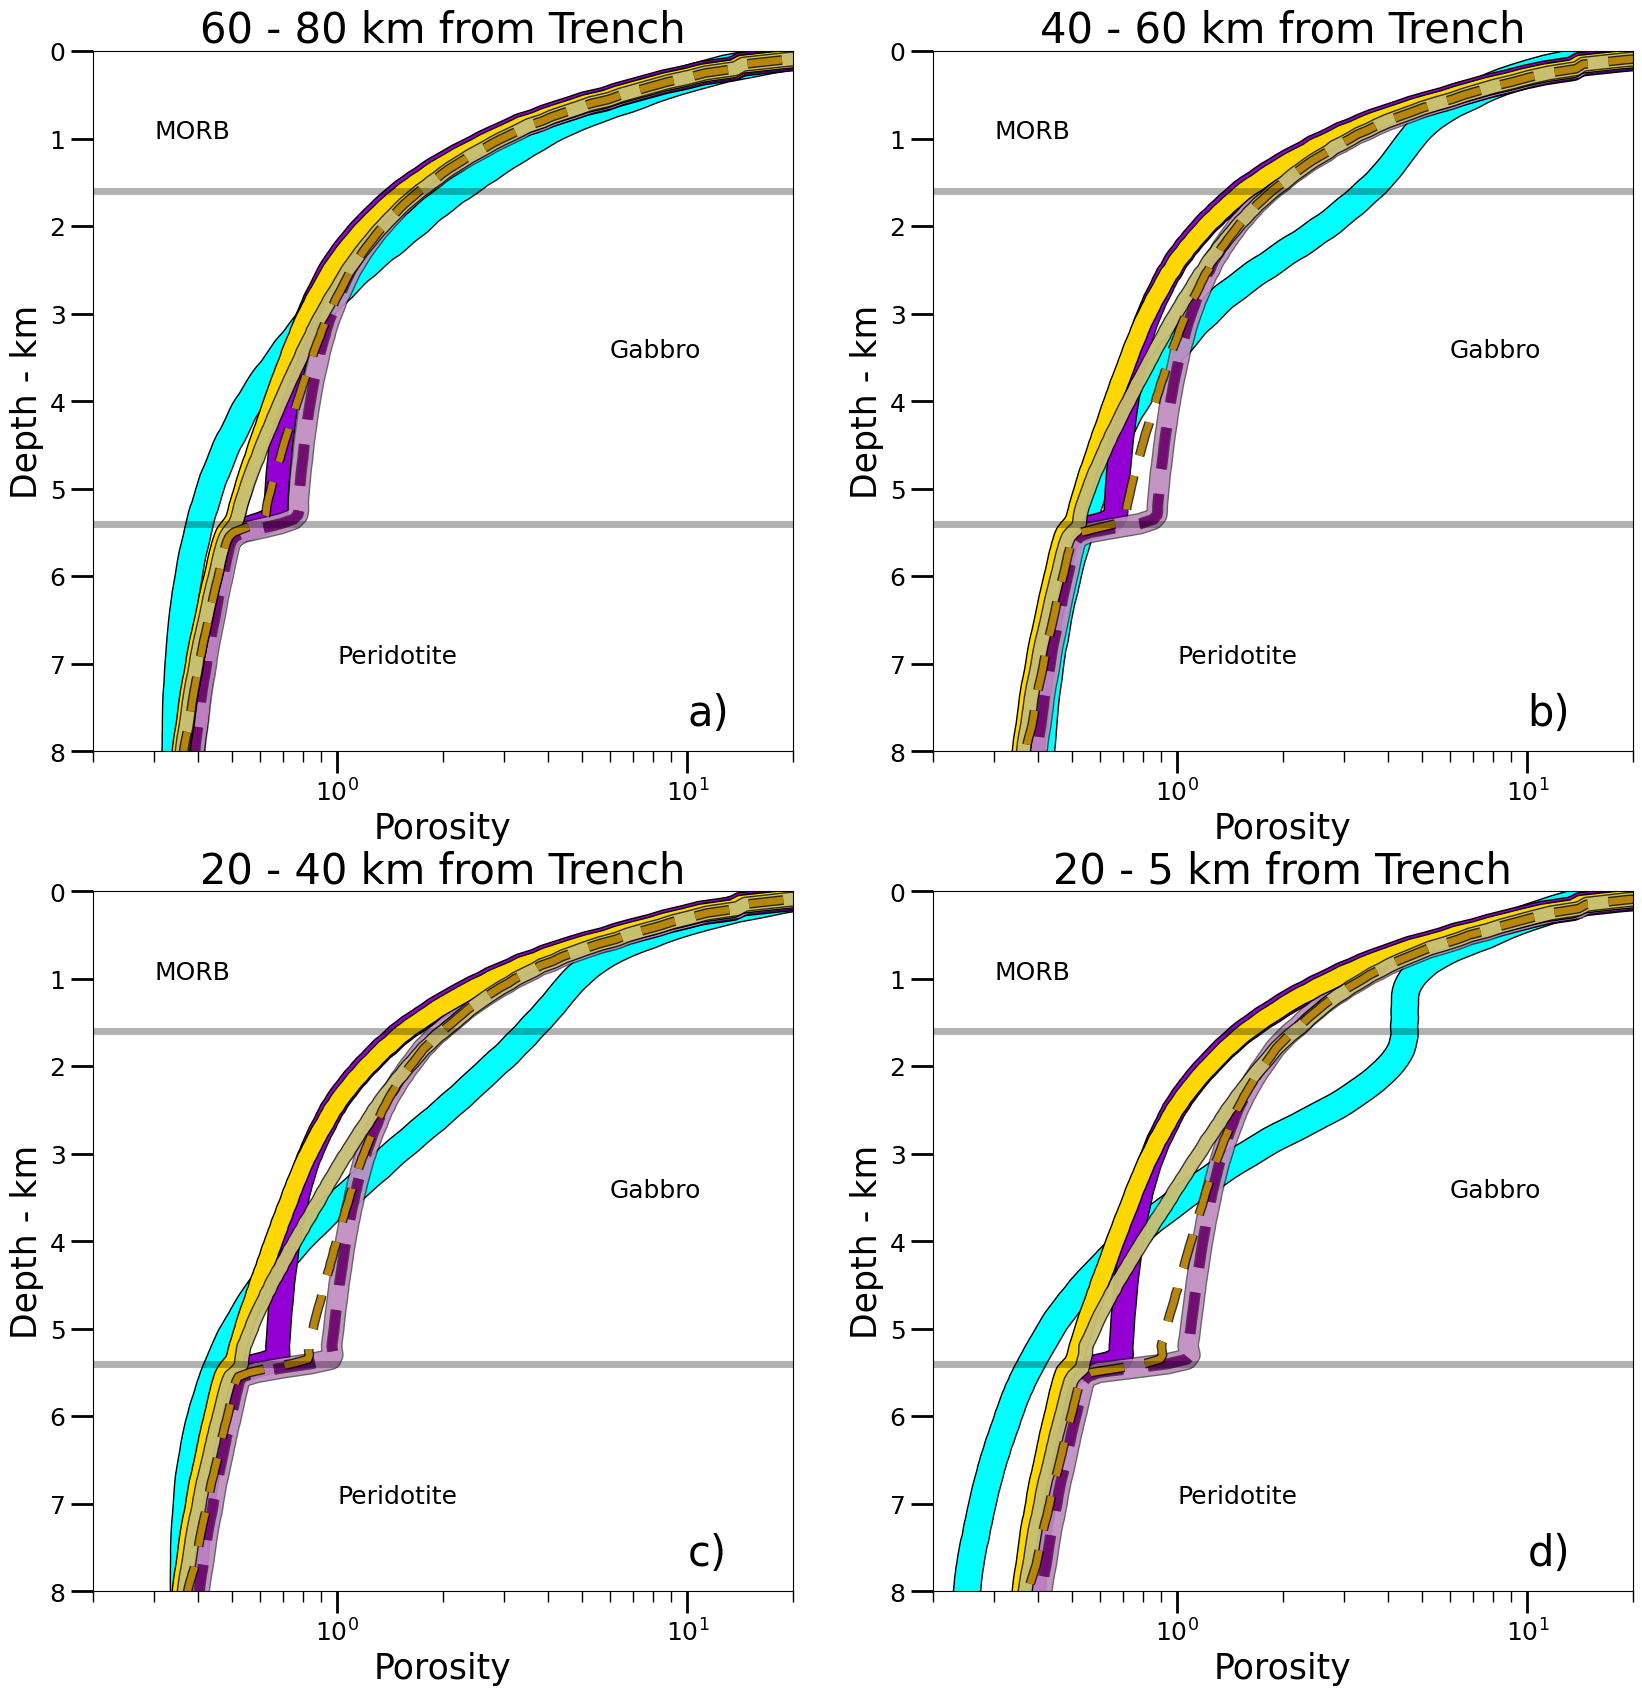

In [8]:
import matplotlib.patheffects as pe

box_width  = 7
box_height = 7
spacing    = 1.4
fig_size_x = 15
fig_size_y = 15

panel_A = [0, (box_height + spacing) / fig_size_y, box_width / fig_size_x, box_height / fig_size_y]
panel_B = [(box_width + spacing) / fig_size_x, (box_height + spacing) / fig_size_y, box_width / fig_size_x, box_height / fig_size_y]
panel_C = [0, 0, box_width / fig_size_x, box_height / fig_size_y]
panel_D = [(box_width + spacing) / fig_size_x, 0, box_width / fig_size_x, box_height / fig_size_y]

fig = plt.figure(dpi=100, figsize=(fig_size_x, fig_size_y))
ax_A = fig.add_axes(panel_A)
ax_B = fig.add_axes(panel_B)
ax_C = fig.add_axes(panel_C)
ax_D = fig.add_axes(panel_D)

ax_A.set_ylim(0, 8)
ax_B.set_ylim(0, 8)
ax_C.set_ylim(0, 8)
ax_D.set_ylim(0, 8)

ax_A.set_xlim(0.2, 20)
ax_B.set_xlim(0.2, 20)
ax_C.set_xlim(0.2, 20)
ax_D.set_xlim(0.2, 20)


ax_A.set_xscale("log")
ax_B.set_xscale("log")
ax_C.set_xscale("log")
ax_D.set_xscale("log")


ax_A.invert_yaxis()
ax_B.invert_yaxis()
ax_C.invert_yaxis()
ax_D.invert_yaxis()

ax_A.set_title("60 - 80 km from Trench", fontsize=30)
ax_B.set_title("40 - 60 km from Trench", fontsize=30)
ax_C.set_title("20 - 40 km from Trench", fontsize=30)
ax_D.set_title("20 - 5 km from Trench", fontsize=30)

ax_A.set_xlabel("Porosity", fontsize=25)
ax_B.set_xlabel("Porosity", fontsize=25)
ax_C.set_xlabel("Porosity", fontsize=25)
ax_D.set_xlabel("Porosity", fontsize=25)

ax_A.set_ylabel("Depth - km", fontsize=25)
ax_B.set_ylabel("Depth - km", fontsize=25)
ax_C.set_ylabel("Depth - km", fontsize=25)
ax_D.set_ylabel("Depth - km", fontsize=25)

ax_A.tick_params(labelsize=18, length=16, width=2)
ax_B.tick_params(labelsize=18, length=16, width=2)
ax_C.tick_params(labelsize=18, length=16, width=2)
ax_D.tick_params(labelsize=18, length=16, width=2)

ax_A.tick_params(labelsize=18, length=8, width=1, which="minor")
ax_B.tick_params(labelsize=18, length=8, width=1, which="minor")
ax_C.tick_params(labelsize=18, length=8, width=1, which="minor")
ax_D.tick_params(labelsize=18, length=8, width=1, which="minor")

###################### NOW PLOT THE CURVES ######################
# 1 is for no faults, 3 is for 2.5x, 4 is for 5x, 5 is for 7.5x, 6 is for 10x, 7 is for 25x
no_flexure_index = 0
flexure_index    = 2
faults_index     = 7
a_val = 0.8

ax_A.plot(depth_averaged_por[3]*100, z_vals_for_bins, c='black', lw=20.5)
ax_B.plot(depth_averaged_por[2]*100, z_vals_for_bins, c='black', lw=20.5)
ax_C.plot(depth_averaged_por[1]*100, z_vals_for_bins, c='black', lw=20.5)
ax_D.plot(depth_averaged_por[0]*100, z_vals_for_bins, c='black', lw=20.5)

ax_A.plot(depth_averaged_por[3]*100, z_vals_for_bins, c='cyan', lw=18.5)
ax_B.plot(depth_averaged_por[2]*100, z_vals_for_bins, c='cyan', lw=18.5)
ax_C.plot(depth_averaged_por[1]*100, z_vals_for_bins, c='cyan', lw=18.5)
ax_D.plot(depth_averaged_por[0]*100, z_vals_for_bins, c='cyan', lw=18.5)

##############################################################################################################################

ax_A.plot(depth_averages_for_models_kj[no_flexure_index][3]*100, z_vals_for_bins, c='black', lw=18, ls='-')
ax_B.plot(depth_averages_for_models_kj[no_flexure_index][2]*100, z_vals_for_bins, c='black', lw=18, ls='-')
ax_C.plot(depth_averages_for_models_kj[no_flexure_index][1]*100, z_vals_for_bins, c='black', lw=18, ls='-')
ax_D.plot(depth_averages_for_models_kj[no_flexure_index][0]*100, z_vals_for_bins, c='black', lw=18, ls='-')

ax_A.plot(depth_averages_for_models_kj[no_flexure_index][3]*100, z_vals_for_bins, c='darkviolet', lw=16, ls='-')
ax_B.plot(depth_averages_for_models_kj[no_flexure_index][2]*100, z_vals_for_bins, c='darkviolet', lw=16, ls='-')
ax_C.plot(depth_averages_for_models_kj[no_flexure_index][1]*100, z_vals_for_bins, c='darkviolet', lw=16, ls='-')
ax_D.plot(depth_averages_for_models_kj[no_flexure_index][0]*100, z_vals_for_bins, c='darkviolet', lw=16, ls='-')

##############################################################################################################################
ax_A.plot(depth_averages_for_models_kj[flexure_index][3]*100, z_vals_for_bins, c='plum', linestyle='-', lw=13.5,
          path_effects=[pe.Stroke(linewidth=15.5, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_B.plot(depth_averages_for_models_kj[flexure_index][2]*100, z_vals_for_bins, c='plum', linestyle='-', lw=13.5,
          path_effects=[pe.Stroke(linewidth=15.5, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_C.plot(depth_averages_for_models_kj[flexure_index][1]*100, z_vals_for_bins, c='plum', linestyle='-', lw=13.5,
          path_effects=[pe.Stroke(linewidth=15.5, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_D.plot(depth_averages_for_models_kj[flexure_index][0]*100, z_vals_for_bins, c='plum', linestyle='-', lw=13.5,
          path_effects=[pe.Stroke(linewidth=15.5, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)

##############################################################################################################################
ax_A.plot(depth_averages_for_models_kj[faults_index][3]*100, z_vals_for_bins, c='purple', linestyle=(0, (5, 3)), lw=6,
          path_effects=[pe.Stroke(linewidth=8, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_B.plot(depth_averages_for_models_kj[faults_index][2]*100, z_vals_for_bins, c='purple', linestyle=(0, (5, 3)), lw=6,
          path_effects=[pe.Stroke(linewidth=8, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_C.plot(depth_averages_for_models_kj[faults_index][1]*100, z_vals_for_bins, c='purple', linestyle=(0, (5, 3)), lw=6,
          path_effects=[pe.Stroke(linewidth=8, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)
ax_D.plot(depth_averages_for_models_kj[faults_index][0]*100, z_vals_for_bins, c='purple', linestyle=(0, (5, 3)), lw=6,
          path_effects=[pe.Stroke(linewidth=8, foreground='black', alpha=a_val-0.2), pe.Normal()], alpha=a_val)

##############################################################################################################################

ax_A.plot(depth_averages_for_models_ha[no_flexure_index][3]*100, z_vals_for_bins, c='black', lw=14)
ax_B.plot(depth_averages_for_models_ha[no_flexure_index][2]*100, z_vals_for_bins, c='black', lw=14)
ax_C.plot(depth_averages_for_models_ha[no_flexure_index][1]*100, z_vals_for_bins, c='black', lw=14)
ax_D.plot(depth_averages_for_models_ha[no_flexure_index][0]*100, z_vals_for_bins, c='black', lw=14)

ax_A.plot(depth_averages_for_models_ha[no_flexure_index][3]*100, z_vals_for_bins, c='gold', lw=12)
ax_B.plot(depth_averages_for_models_ha[no_flexure_index][2]*100, z_vals_for_bins, c='gold', lw=12)
ax_C.plot(depth_averages_for_models_ha[no_flexure_index][1]*100, z_vals_for_bins, c='gold', lw=12)
ax_D.plot(depth_averages_for_models_ha[no_flexure_index][0]*100, z_vals_for_bins, c='gold', lw=12)

##############################################################################################################################
ax_A.plot(depth_averages_for_models_ha[flexure_index][3]*100, z_vals_for_bins, c='khaki', linestyle='-', lw=9,
          path_effects=[pe.Stroke(linewidth=11, foreground='black', alpha=a_val), pe.Normal()], alpha=a_val)
ax_B.plot(depth_averages_for_models_ha[flexure_index][2]*100, z_vals_for_bins, c='khaki', linestyle='-', lw=9,
          path_effects=[pe.Stroke(linewidth=11, foreground='black', alpha=a_val), pe.Normal()], alpha=a_val)
ax_C.plot(depth_averages_for_models_ha[flexure_index][1]*100, z_vals_for_bins, c='khaki', linestyle='-', lw=9,
          path_effects=[pe.Stroke(linewidth=11, foreground='black', alpha=a_val), pe.Normal()], alpha=a_val)
ax_D.plot(depth_averages_for_models_ha[flexure_index][0]*100, z_vals_for_bins, c='khaki', linestyle='-', lw=9,
          path_effects=[pe.Stroke(linewidth=11, foreground='black', alpha=a_val), pe.Normal()], alpha=a_val)

##############################################################################################################################
ax_A.plot(depth_averages_for_models_ha[faults_index][3]*100, z_vals_for_bins, c='darkgoldenrod', linestyle=(0, (5, 3)), lw=5,
          path_effects=[pe.Stroke(linewidth=7, foreground='black', alpha=a_val), pe.Normal()], alpha=1)
ax_B.plot(depth_averages_for_models_ha[faults_index][2]*100, z_vals_for_bins, c='darkgoldenrod', linestyle=(0, (5, 3)), lw=5,
          path_effects=[pe.Stroke(linewidth=7, foreground='black', alpha=a_val), pe.Normal()], alpha=1)
ax_C.plot(depth_averages_for_models_ha[faults_index][1]*100, z_vals_for_bins, c='darkgoldenrod', linestyle=(0, (5, 3)), lw=5,
          path_effects=[pe.Stroke(linewidth=7, foreground='black', alpha=a_val), pe.Normal()], alpha=1)
ax_D.plot(depth_averages_for_models_ha[faults_index][0]*100, z_vals_for_bins, c='darkgoldenrod', linestyle=(0, (5, 3)), lw=5,
          path_effects=[pe.Stroke(linewidth=7, foreground='black', alpha=a_val), pe.Normal()], alpha=1)

ax_A.axhline(1.6, ls='-', c='k', alpha=0.3, lw=5)
ax_B.axhline(1.6, ls='-', c='k', alpha=0.3, lw=5)
ax_C.axhline(1.6, ls='-', c='k', alpha=0.3, lw=5)
ax_D.axhline(1.6, ls='-', c='k', alpha=0.3, lw=5)

ax_A.axhline(5.4, ls='-', c='k', alpha=0.3, lw=5)
ax_B.axhline(5.4, ls='-', c='k', alpha=0.3, lw=5)
ax_C.axhline(5.4, ls='-', c='k', alpha=0.3, lw=5)
ax_D.axhline(5.4, ls='-', c='k', alpha=0.3, lw=5)

ax_A.text(10, 7.7, "a)", fontsize=30)
ax_B.text(10, 7.7, "b)", fontsize=30)
ax_C.text(10, 7.7, "c)", fontsize=30)
ax_D.text(10, 7.7, "d)", fontsize=30)

ax_A.text(0.3, 1.0, "MORB", fontsize=18)
ax_A.text(6, 3.5, "Gabbro", fontsize=18)
ax_A.text(1.0, 7.0, "Peridotite", fontsize=18)

ax_B.text(0.3, 1.0, "MORB", fontsize=18)
ax_B.text(6, 3.5, "Gabbro", fontsize=18)
ax_B.text(1.0, 7.0, "Peridotite", fontsize=18)

ax_C.text(0.3, 1.0, "MORB", fontsize=18)
ax_C.text(6, 3.5, "Gabbro", fontsize=18)
ax_C.text(1.0, 7.0, "Peridotite", fontsize=18)

ax_D.text(0.3, 1.0, "MORB", fontsize=18)
ax_D.text(6, 3.5, "Gabbro", fontsize=18)
ax_D.text(1.0, 7.0, "Peridotite", fontsize=18)

# plt.savefig("Figures/figure_3.png", bbox_inches="tight")
plt.show()